In [1]:
import numpy as np
import random
import os
import shutil

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

map_dir = 'map 5'

n=2
models =[]
histories =[]

remove prev saved database:

In [2]:
dir_path = './data/humanModel_v0_dataset_split'
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
else:
    print("File not found in the directory")

# Part 1 - Data Preprocessing

## Split into train , test data

In [3]:
# train, test split
splitfolders.ratio('./data/humanModel_v0_dataset/', output="./data/humanModel_v0_dataset_split", ratio=(0.8, 0.2))

Copying files: 5790 files [00:00, 16221.39 files/s]


### Preprocessing the Training set

In [4]:
batch_size = 64
IMG_SIZE = 10

datagen = ImageDataGenerator(rescale = 1./255)
train = datagen.flow_from_directory('./data/humanModel_v0_dataset_split/train',
                                          target_size = (IMG_SIZE,IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

test = datagen.flow_from_directory('./data/humanModel_v0_dataset_split/val',
                                            target_size = (IMG_SIZE, IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

Found 4629 images belonging to 5 classes.
Found 1161 images belonging to 5 classes.


## View some data

In [5]:
def build_model():
  num_classes = 5

  model = Sequential([
    layers.Conv2D(8, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=[IMG_SIZE,IMG_SIZE,3]),
    layers.Conv2D(16, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),# training=True),
    layers.Flatten(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(num_classes, activation='softmax')
  ])
  return model

In [6]:
for i in range(n):
    models.append(build_model())

    models[i].compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print("fit {} ...".format(models[i]))
    epochs=200
    histories.append(models[i].fit(train, validation_data=test, epochs=epochs))
    # Save the entire model as a SavedModel.
    models[i].save('./data/'+map_dir+'/humanModel_'+ str(i) +'_v0.h5')

2022-05-09 17:37:05.368093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 17:37:05.375906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 17:37:05.376251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 17:37:05.376914: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

fit <keras.engine.sequential.Sequential object at 0x7f3cf29bc850> ...


2022-05-09 17:37:06.096886: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/home/ido/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


Epoch 1/200


2022-05-09 17:37:06.719261: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-05-09 17:37:06.871731: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


73/73 [==============================] - 2s 12ms/step - loss: 1.5598 - accuracy: 0.3640 - val_loss: 1.4537 - val_accuracy: 0.3747
Epoch 2/200
73/73 [==============================] - 1s 9ms/step - loss: 1.3614 - accuracy: 0.4394 - val_loss: 1.1846 - val_accuracy: 0.5220
Epoch 3/200
73/73 [==============================] - 1s 9ms/step - loss: 1.1603 - accuracy: 0.5742 - val_loss: 1.0543 - val_accuracy: 0.6632
Epoch 4/200
73/73 [==============================] - 1s 10ms/step - loss: 1.0067 - accuracy: 0.6559 - val_loss: 0.8826 - val_accuracy: 0.7235
Epoch 5/200
73/73 [==============================] - 1s 9ms/step - loss: 0.9129 - accuracy: 0.6993 - val_loss: 0.8097 - val_accuracy: 0.7218
Epoch 6/200
73/73 [==============================] - 1s 9ms/step - loss: 0.8563 - accuracy: 0.7267 - val_loss: 0.7630 - val_accuracy: 0.7373
Epoch 7/200
73/73 [==============================] - 1s 10ms/step - loss: 0.8111 - accuracy: 0.7362 - val_loss: 0.7352 - val_accuracy: 0.7494
Epoch 8/200
73/73 [===

In [7]:
def eval(model, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    loss, accuracy = model.evaluate(test)
    print('Test accuracy :', accuracy)

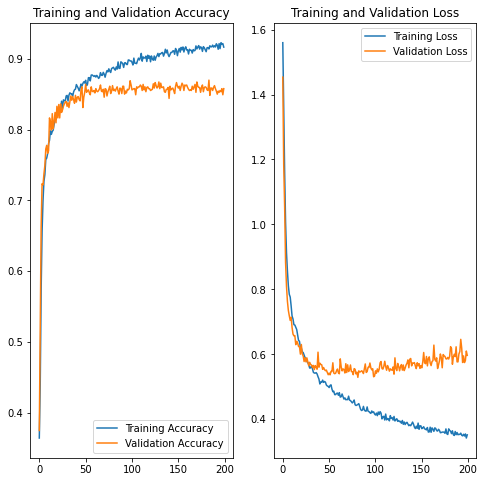

19/19 [==============================] - 0s 7ms/step - loss: 0.5966 - accuracy: 0.8579
Test accuracy : 0.8578811287879944


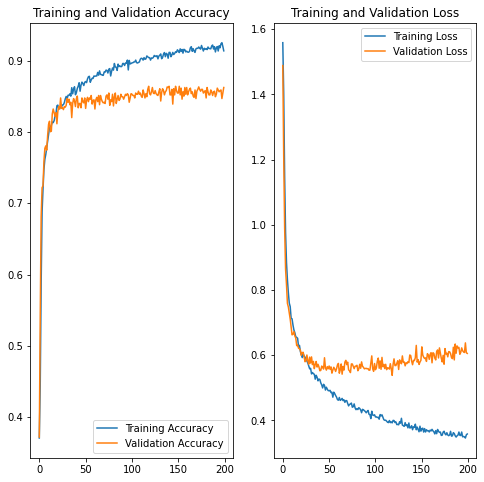

19/19 [==============================] - 0s 8ms/step - loss: 0.6053 - accuracy: 0.8622
Test accuracy : 0.8621877431869507


In [8]:
for i in range(n):
    eval(models[i], histories[i])

### Predict on new data

In [10]:
path = "./data/humanModel_v0_dataset_split/val/38/-Ms8axULhIjj8UI3-s6g_13.png"

img = keras.preprocessing.image.load_img(
    path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = img_array/255

for i in range(n):
    predictions = models[i].predict(img_array)[0]

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(np.argmax(predictions), 100 * np.max(predictions))
    )



This image most likely belongs to 2 with a 99.86 percent confidence.
This image most likely belongs to 2 with a 99.96 percent confidence.
